### Моделирование и предсказание поведения агентов финансовых систем

#### Лабораторная 1

Глеб Блазнов

##### Загрузка и чтение данных

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"giblaznov","key":"21b93b19719eca401a1d905b383576e9"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [6]:
!mkdir /content/kaggle

In [7]:
!cp kaggle.json /content/kaggle

In [10]:
!chmod 600 /content/kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [11]:
!kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/world-population-dataset                     World Population Dataset                             17KB  2022-08-31 11:20:04           7462        232  1.0              
thedevastator/mcdonalds-ice-cream-machines-broken-timeseries   McDonalds Ice Cream Machines Breaking - Timeseries  404KB  2022-09-14 23:51:09            584         29  1.0              
pantanjali/unemployment-dataset                                Unemployment dataset                                 17KB  2022-09-08 08:26:10           1639         57  1.0              
evangower/premier-league-match-data                            Pr

In [12]:
!kaggle datasets download -d sokolovaleks/alfabattle2-sandbox

100% 4.86G/4.86G [00:38<00:00, 175MB/s]
100% 4.86G/4.86G [00:38<00:00, 136MB/s]


In [1]:
!mkdir /content/alfabattle_data

In [13]:
!unzip alfabattle2-sandbox.zip -d alfabattle_data

Archive:  alfabattle2-sandbox.zip
  inflating: alfabattle_data/alfabattle2_sand_alfabattle2_alpha_sample (1).csv  
  inflating: alfabattle_data/alfabattle2_sand_alfabattle2_test_target_contest.csv  
  inflating: alfabattle_data/alfabattle2_sand_alfabattle2_test_transactions_contest/test_transactions_contest/part_000_1063620_to_1074462.parquet  
  inflating: alfabattle_data/alfabattle2_sand_alfabattle2_test_transactions_contest/test_transactions_contest/part_001_1074463_to_1085303.parquet  
  inflating: alfabattle_data/alfabattle2_sand_alfabattle2_test_transactions_contest/test_transactions_contest/part_002_1085304_to_1095174.parquet  
  inflating: alfabattle_data/alfabattle2_sand_alfabattle2_test_transactions_contest/test_transactions_contest/part_003_1095175_to_1105002.parquet  
  inflating: alfabattle_data/alfabattle2_sand_alfabattle2_test_transactions_contest/test_transactions_contest/part_004_1105003_to_1116054.parquet  
  inflating: alfabattle_data/alfabattle2_sand_alfabattle2_tes

In [15]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 2.8 MB/s 
     |████████████████████████████████| 1.1 MB 16.9 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=cc6cecc8866e88e609e76739d615f295d736460d1b86ecc2b95798c16481a673
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=4522633c70c37df810daecae87967eebc679f4a32c65d462466ab075ffe2f06a
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [16]:
import pandas as pd
import pandas_profiling
import tqdm

import os
import gc
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import umap
%pylab inline

pd.set_option('display.max_columns', None)

Populating the interactive namespace from numpy and matplotlib


In [17]:
PATH_TO_TRAIN_TARGET = '/content/alfabattle_data/alfabattle2_sand_alfabattle2_train_target.csv'
PATH_TO_TEST_TARGET = '/content/alfabattle_data/alfabattle2_sand_alfabattle2_test_target_contest.csv'

PATH_TO_TRAIN = '/content/alfabattle_data/alfabattle2_sand_alfabattle2_train_transactions_contest/train_transactions_contest'
PATH_TO_TEST = '/content/alfabattle_data/alfabattle2_sand_alfabattle2_test_transactions_contest/test_transactions_contest'

In [18]:
def read_parquet_dataset_from_local(path_to_dataset: str, 
                                    start_from: int = 0,
                                    num_parts_to_read: int = 2, 
                                    columns=None, 
                                    verbose=False,
                                    info_num_parts=False) -> pd.DataFrame:
    """
    читает num_parts_to_read партиций, преобразует их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :return: pd.DataFrame
    """

    res = []
    list_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset) 
                              if filename.startswith('part')])
    if info_num_parts:
        print(f'Кол-во партиций в папке: {len(list_paths)}')
    start_from = max(0, start_from)
    list_path_to_partitions = list_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for path_to_partition in list_path_to_partitions:
            print(path_to_pirtition)
    for path_to_parquet in tqdm.tqdm_notebook(list_path_to_partitions, 
                                              desc="Читаем файлы:"):
        temp_parquet = pd.read_parquet(path_to_parquet,columns=columns)
        res.append(temp_parquet)
        del temp_parquet
        gc.collect()
    return pd.concat(res).reset_index(drop=True)

In [26]:
temp_df = read_parquet_dataset_from_local(PATH_TO_TRAIN,start_from=0, num_parts_to_read=5, columns=['app_id','amnt','mcc_category','hour','day_of_week','weekofyear'], info_num_parts=True)

Кол-во партиций в папке: 50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Читаем файлы::   0%|          | 0/5 [00:00<?, ?it/s]

##### Профили активности пользователей по часам

In [28]:
hour_activity = temp_df[['app_id','hour','amnt']].groupby(['app_id','hour']).agg('count').unstack('hour', fill_value=0)['amnt']

In [29]:
hour_activity=hour_activity.div(hour_activity.max(axis=1), axis=0)

In [30]:
reducer = umap.UMAP(min_dist=0,n_neighbors=30,random_state=15)

In [31]:
hour_emb = reducer.fit_transform(hour_activity)

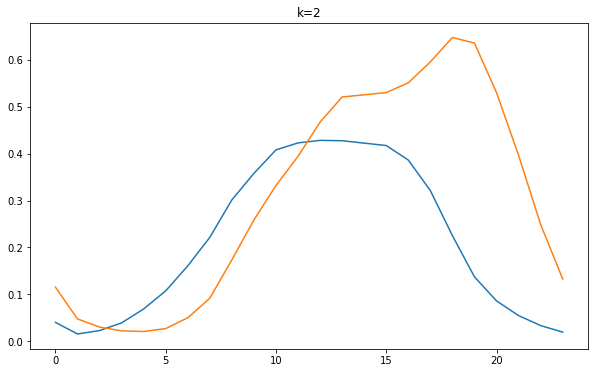

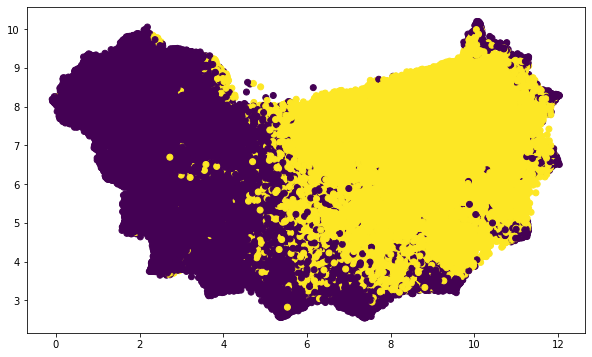

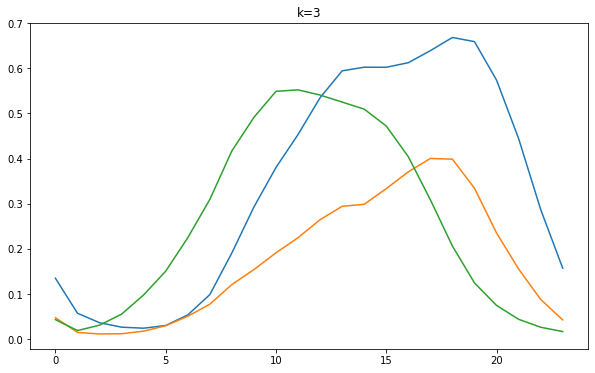

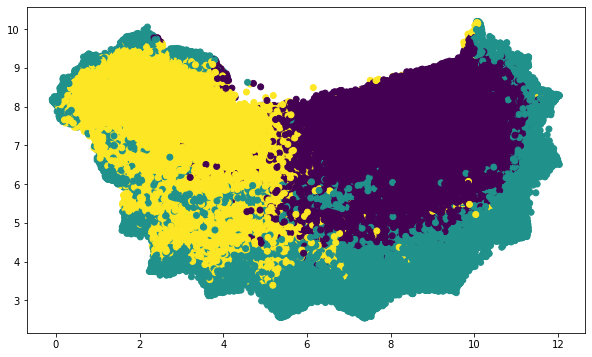

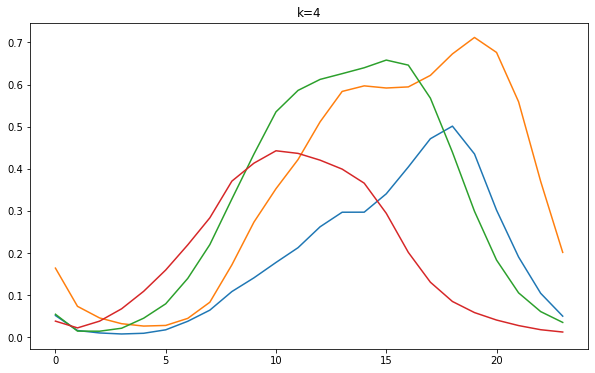

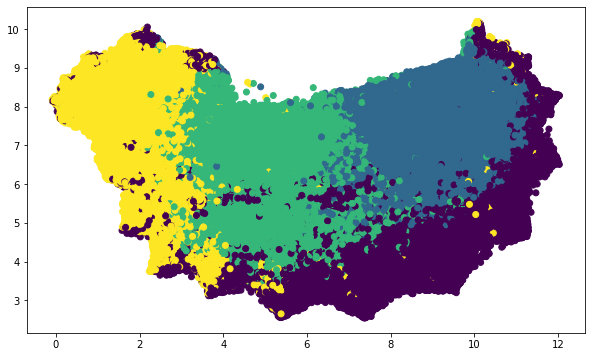

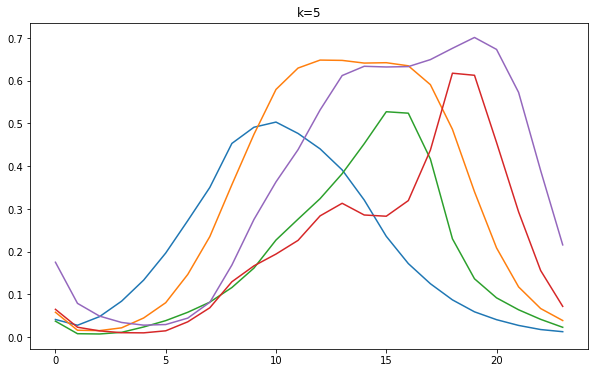

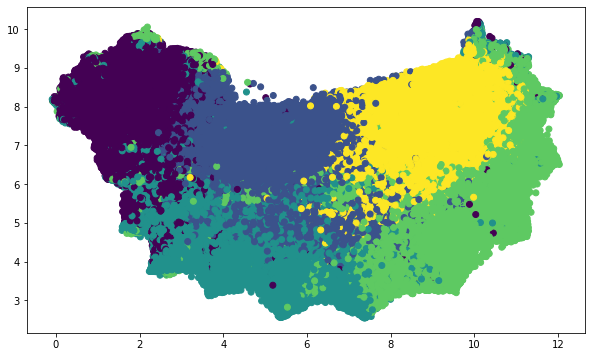

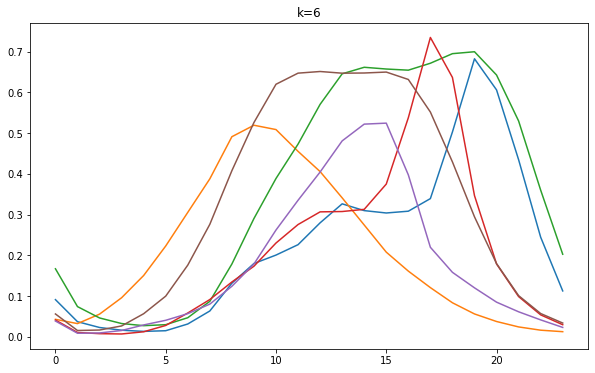

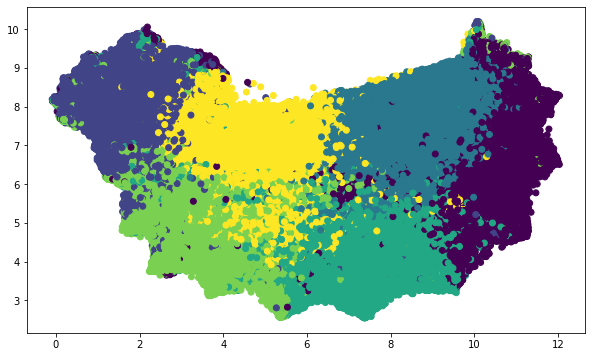

In [32]:
hour_scores=[]
for i in range(2,7):
  clustering_res = KMeans(n_clusters=i, random_state=15).fit(hour_activity)
  silhouette = silhouette_score(hour_activity,clustering_res.labels_)
  ch = calinski_harabasz_score(hour_activity,clustering_res.labels_)
  db = davies_bouldin_score(hour_activity,clustering_res.labels_)
  tmp_scores = {"n_clusters": i,
                "silhouette_score": silhouette,
                 "calinski_harabasz_score": ch,
                "davies_bouldin_score": db,
                 }
  hour_scores.append(tmp_scores)
  plt.figure(figsize=(10,6))
  plt.title('k='+str(i))
  for k in range(i):
        plt.plot(clustering_res.cluster_centers_[k])
  plt.show()
  plt.figure(figsize=(10,6))
  plt.scatter(hour_emb[ :, 0], hour_emb[ :, 1],c=clustering_res.labels_)
  plt.show()

In [33]:
hour_scores = pd.DataFrame(hour_scores)
hour_scores

,n_clusters,silhouette_score,calinski_harabasz_score,davies_bouldin_score
0,2,0.154790,22360.965986,2.181209
1,3,0.129492,17676.618106,2.239510
2,4,0.112255,15308.131829,2.115750
3,5,0.106213,13464.873983,2.214568
4,6,0.105357,12040.205738,2.220595


Выделенные профили пользователей по часовой активности (k=5):

1. Синяя линия: "жаворонки" - рост транзакционной активности до 10 утра, потом плавный спад

2. Оранжевая линия: рост активности до 11 часов утра, потом долгий пик примерно до 16 чаосв дня и резкий спад

3. Зелёная линия: медленный подъём до 15 часов и резкий спад после

4. Краснаяя линия: "совы" - низкая медленно нарастающая активность в течтение дня, резкий рост с пиком вечером

5. Фиолетовая линия: низкая активность рано утром, стабильная в течение всего дня

##### Профили активности пользователей по дням недели

In [34]:
day_activity = temp_df[['app_id','day_of_week','amnt']].groupby(['app_id','day_of_week']).agg('count').unstack('day_of_week', fill_value=0)['amnt']

In [35]:
day_activity=day_activity.div(day_activity.max(axis=1), axis=0)

In [36]:
day_emb = reducer.fit_transform(day_activity)

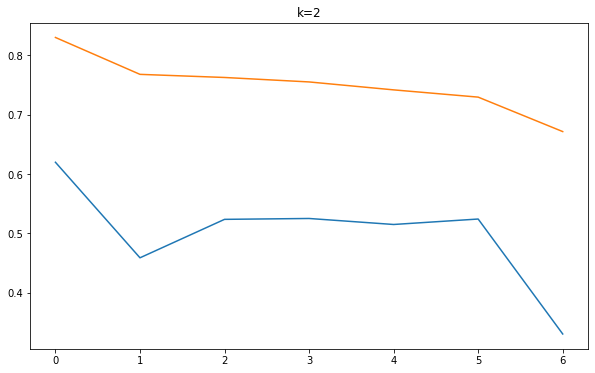

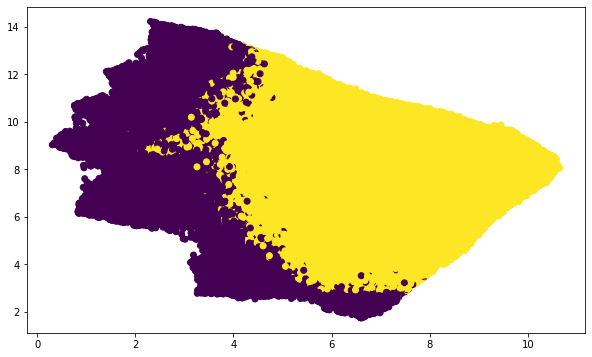

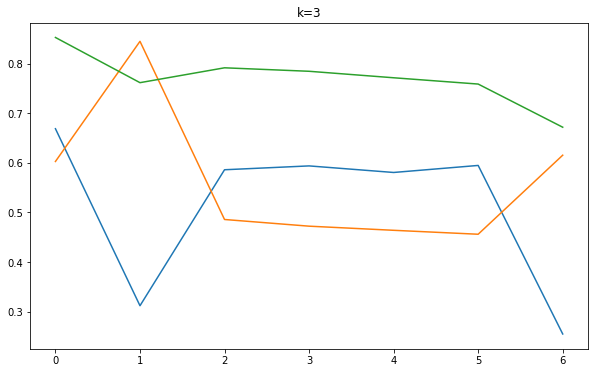

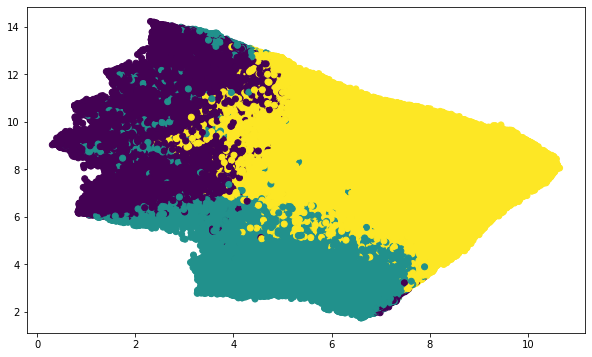

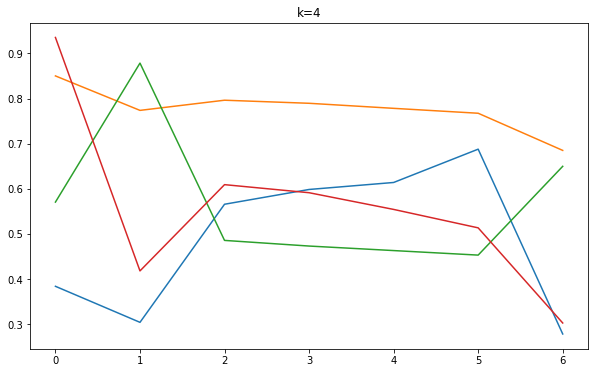

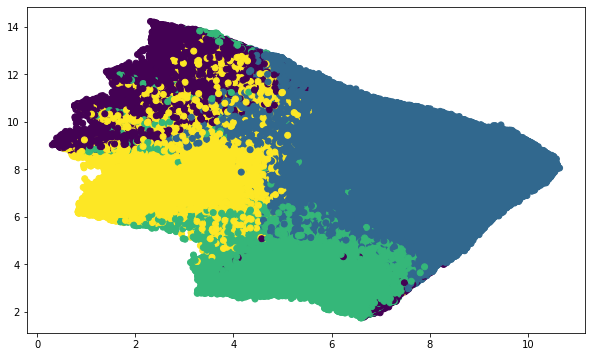

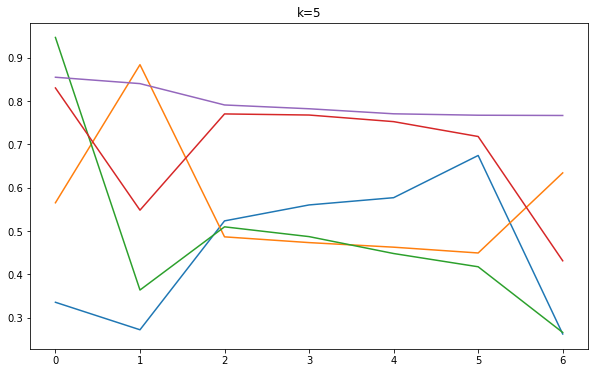

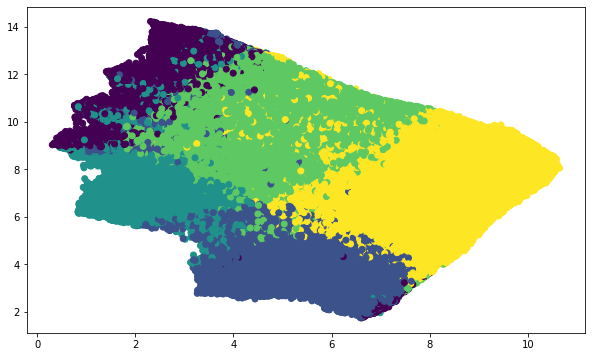

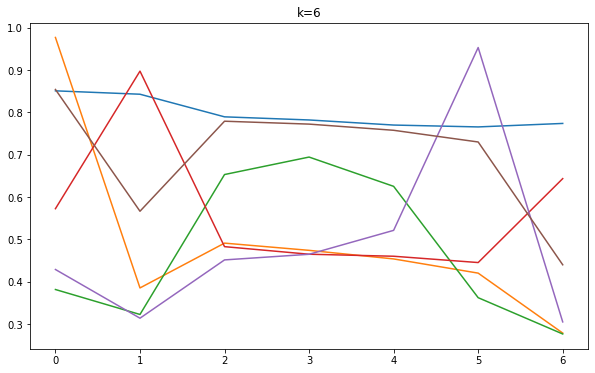

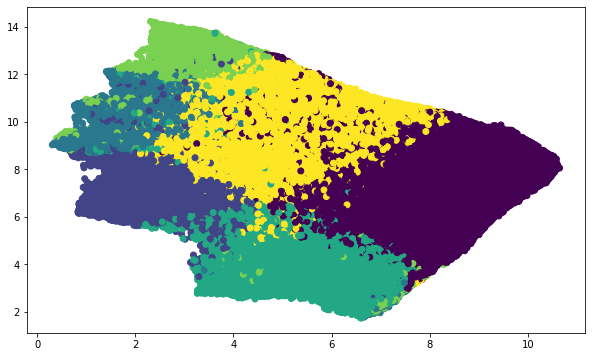

In [37]:
day_scores=[]
for i in range(2,7):
  clustering_res = KMeans(n_clusters=i, random_state=15).fit(day_activity)
  silhouette = silhouette_score(day_activity,clustering_res.labels_)
  ch = calinski_harabasz_score(day_activity,clustering_res.labels_)
  db = davies_bouldin_score(day_activity,clustering_res.labels_)
  tmp_scores = {"n_clusters": i,
                "silhouette_score": silhouette,
                 "calinski_harabasz_score": ch,
                "davies_bouldin_score": db,
                 }
  day_scores.append(tmp_scores)
  plt.figure(figsize=(10,6))
  plt.title('k='+str(i))
  for k in range(i):
        plt.plot(clustering_res.cluster_centers_[k])
  plt.show()
  plt.figure(figsize=(10,6))
  plt.scatter(day_emb[ :, 0], day_emb[ :, 1],c=clustering_res.labels_)
  plt.show()

In [38]:
day_scores = pd.DataFrame(day_scores)
day_scores

,n_clusters,silhouette_score,calinski_harabasz_score,davies_bouldin_score
0,2,0.255133,31184.124833,1.825122
1,3,0.222874,25247.786815,1.792461
2,4,0.214574,21247.264537,1.861557
3,5,0.149307,19049.407703,1.864438
4,6,0.151002,17204.842740,1.865746


Выделенные профили пользователей по дневной активности (k=3):

1. Синяя линия: покупки в понедельник и со среды по субботу

2. Оранжевая линия: кто делает покупки обычно в понедельник, вторник и воскресенье

3. Зелёная линия: равномерная активность в течение всей недели

##### Профили активности пользователей по месяцам

In [39]:
import datetime
from dateutil.relativedelta import relativedelta
def month_from_week(x):
  return (datetime.date(2021, 1, 1) + relativedelta(weeks=+x)).month

In [40]:
temp_df['month'] = temp_df['weekofyear'].apply(month_from_week)

In [41]:
month_activity = temp_df[['app_id','month','amnt']].groupby(['app_id','month']).agg('count').unstack('month', fill_value=0)['amnt']

In [42]:
month_activity=month_activity.div(month_activity.max(axis=1), axis=0)

In [43]:
month_emb = reducer.fit_transform(month_activity)

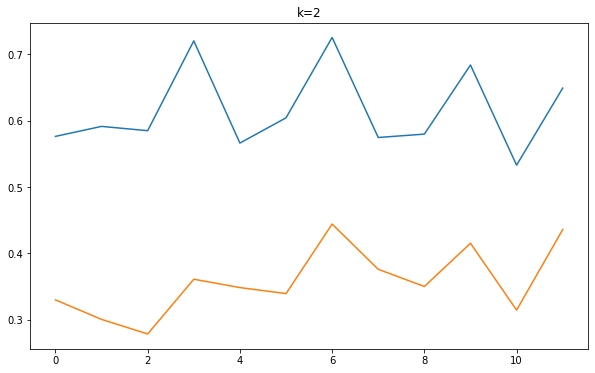

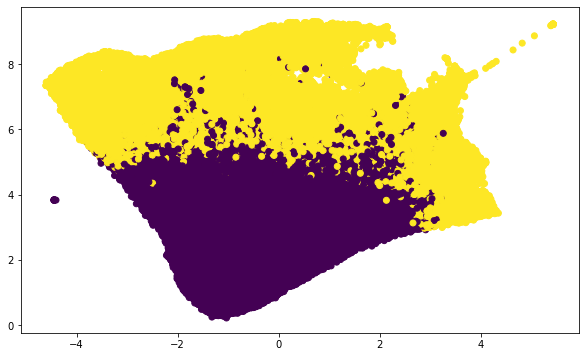

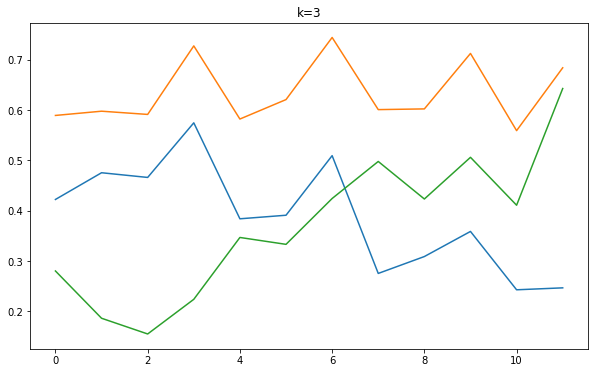

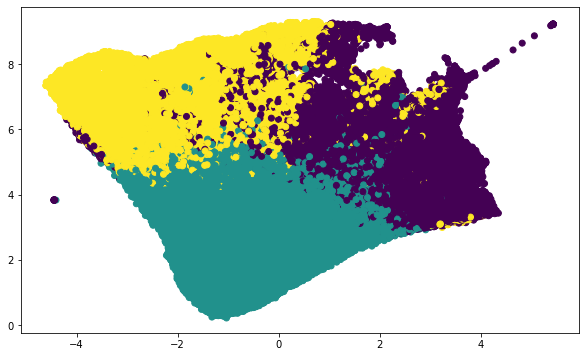

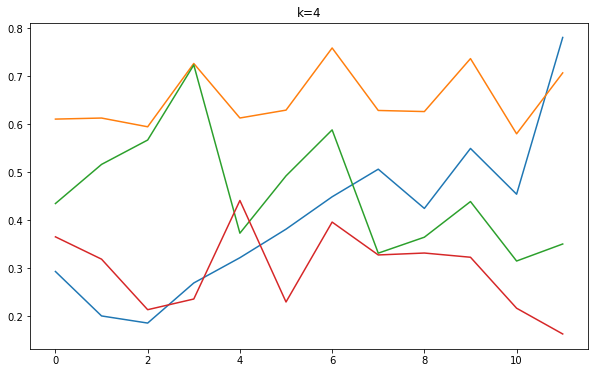

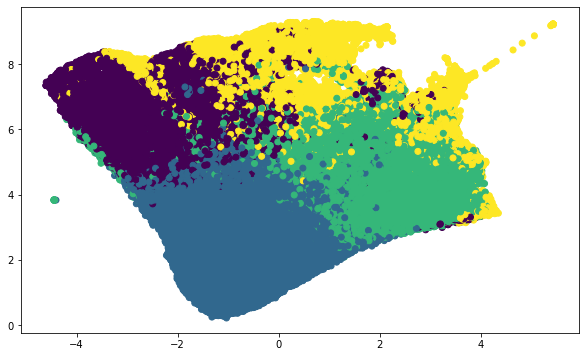

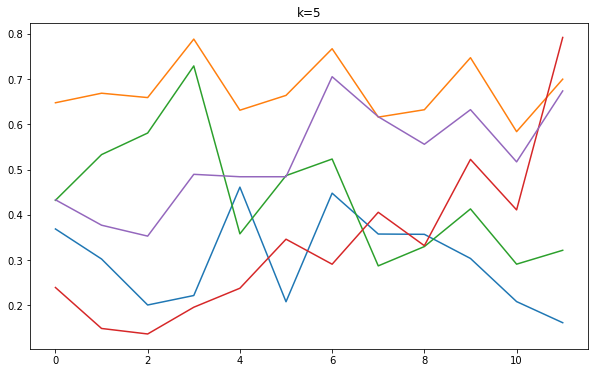

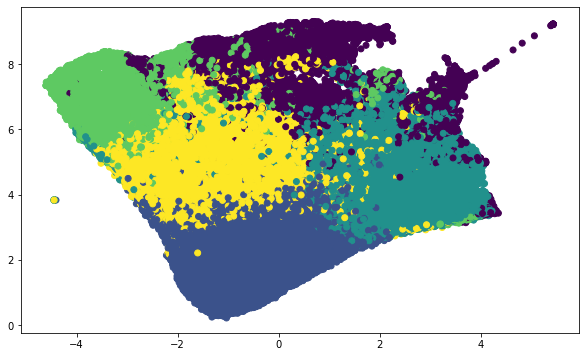

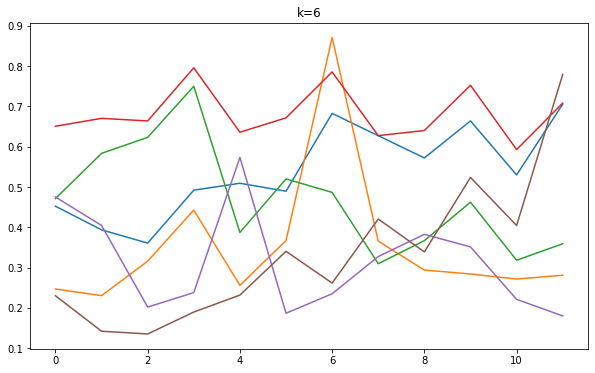

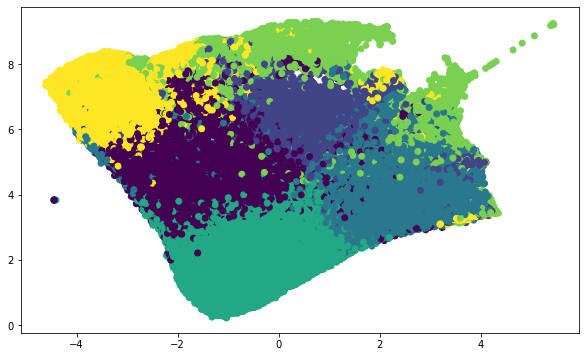

In [44]:
month_scores=[]
for i in range(2,7):
  clustering_res = KMeans(n_clusters=i, random_state=15).fit(month_activity)
  silhouette = silhouette_score(month_activity,clustering_res.labels_)
  ch = calinski_harabasz_score(month_activity,clustering_res.labels_)
  db = davies_bouldin_score(month_activity,clustering_res.labels_)
  tmp_scores = {"n_clusters": i,
                "silhouette_score": silhouette,
                 "calinski_harabasz_score": ch,
                "davies_bouldin_score": db,
                 }
  month_scores.append(tmp_scores)
  plt.figure(figsize=(10,6))
  plt.title('k='+str(i))
  for k in range(i):
        plt.plot(clustering_res.cluster_centers_[k])
  plt.show()
  plt.figure(figsize=(10,6))
  plt.scatter(month_emb[ :, 0], month_emb[ :, 1],c=clustering_res.labels_)
  plt.show()

In [46]:
month_scores = pd.DataFrame(month_scores)
month_scores

,n_clusters,silhouette_score,calinski_harabasz_score,davies_bouldin_score
0,2,0.182701,25968.328565,2.022381
1,3,0.166986,19278.841968,2.295369
2,4,0.133969,15308.132240,2.419022
3,5,0.102276,13074.548811,2.413195
4,6,0.102405,11727.071064,2.283828


Выделенные профили пользователей по месячной активности (k=4):

1. Синяя линия: нарастающая активность в течение года

2. Оранжевая линия: равномерно высокая активность

3. Зелёная линия: высокая активность с января по апрель, потом волнообраный спад

4. Красная линия: низкая активность в течение всего года с пиком в мае

##### Профили интересов пользователей по mcc-кодам

In [47]:
mcc_activity = temp_df[['app_id','mcc_category','amnt']].groupby(['app_id','mcc_category']).agg('count').unstack('mcc_category', fill_value=0)['amnt']

In [48]:
mcc_activity=mcc_activity.div(mcc_activity.max(axis=1), axis=0)

In [49]:
mcc_emb = reducer.fit_transform(mcc_activity)

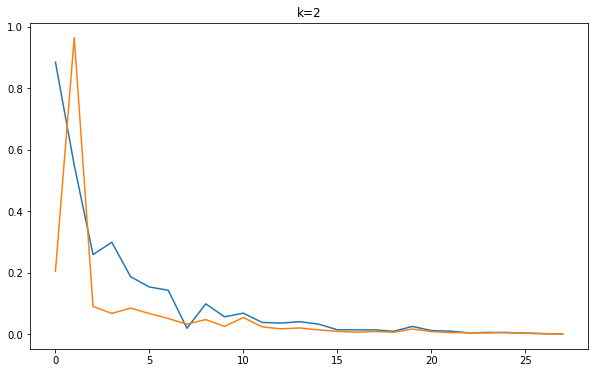

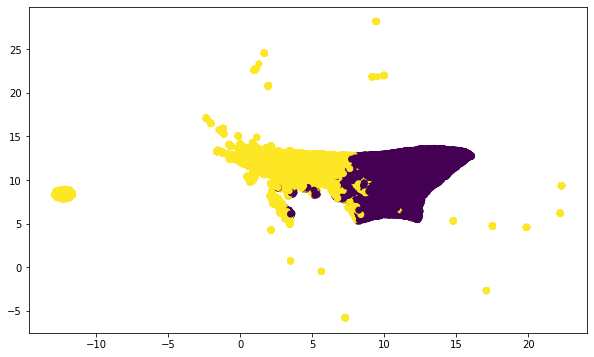

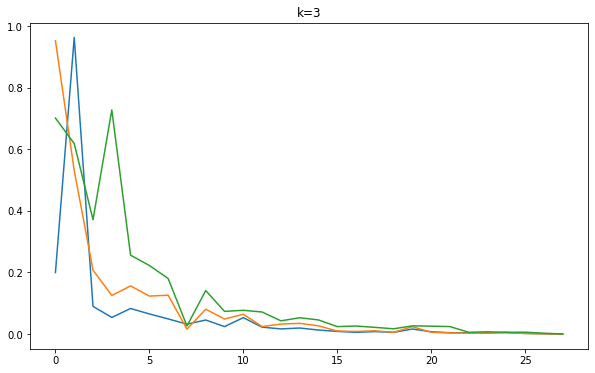

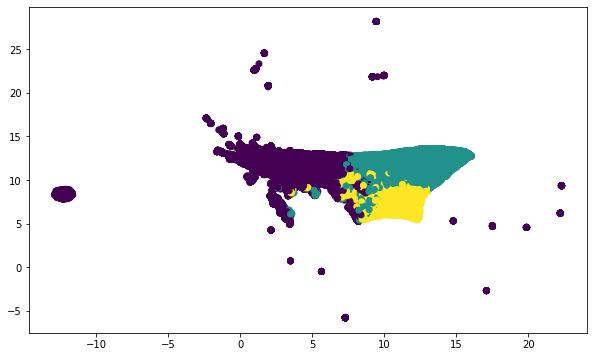

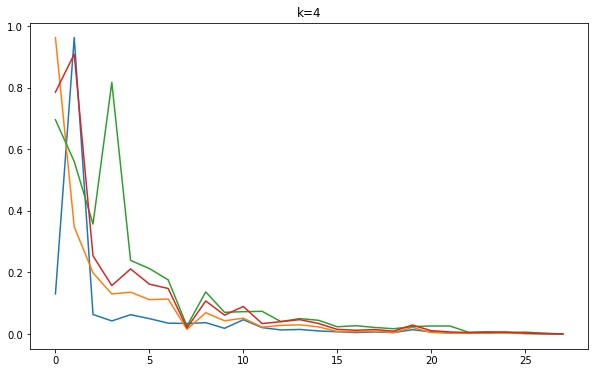

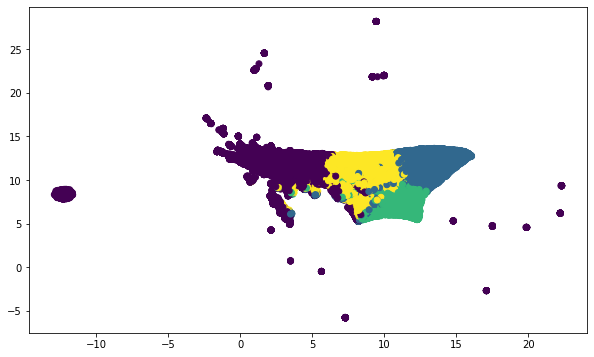

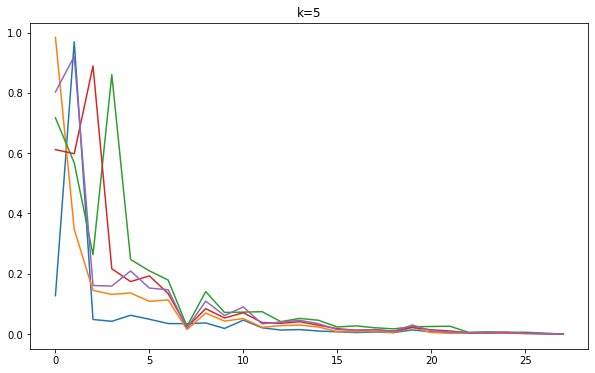

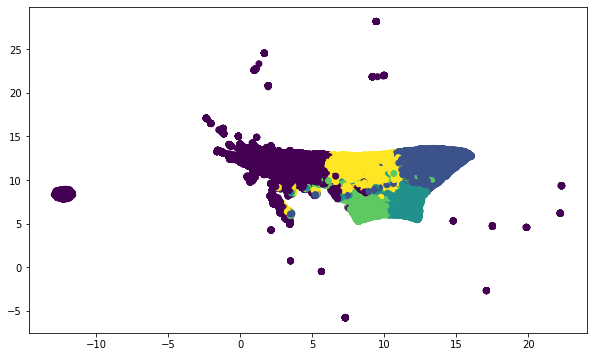

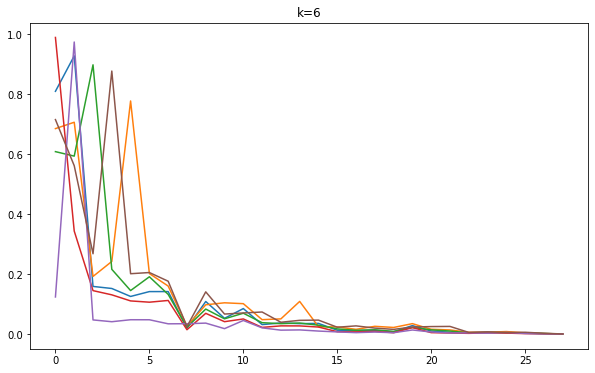

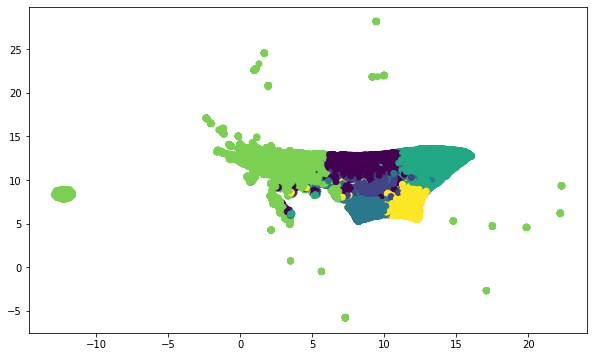

In [50]:
mcc_scores=[]
for i in range(2,7):
  clustering_res = KMeans(n_clusters=i, random_state=15).fit(mcc_activity)
  silhouette = silhouette_score(mcc_activity,clustering_res.labels_)
  ch = calinski_harabasz_score(mcc_activity,clustering_res.labels_)
  db = davies_bouldin_score(mcc_activity,clustering_res.labels_)
  tmp_scores = {"n_clusters": i,
                "silhouette_score": silhouette,
                 "calinski_harabasz_score": ch,
                "davies_bouldin_score": db,
                 }
  mcc_scores.append(tmp_scores)
  plt.figure(figsize=(10,6))
  plt.title('k='+str(i))
  for k in range(i):
        plt.plot(clustering_res.cluster_centers_[k])
  plt.show()
  plt.figure(figsize=(10,6))
  plt.scatter(mcc_emb[ :, 0], mcc_emb[ :, 1],c=clustering_res.labels_)
  plt.show()

In [51]:
mcc_scores = pd.DataFrame(mcc_scores)
mcc_scores

,n_clusters,silhouette_score,calinski_harabasz_score,davies_bouldin_score
0,2,0.317737,48427.941049,1.289385
1,3,0.323345,37512.248280,1.610797
2,4,0.286070,32289.027080,1.611393
3,5,0.298622,30183.147337,1.446768
4,6,0.300615,27235.268783,1.464594


Выделенные профили интересов по категориям mcc кодов (k=5):

1. Синяя линия: почти вся активность лежит в категории 1

2. Оранжевая линия: основной интерес в категории 0

3. Зелёная линия: наибольшая акивность в 0, 1 и 3 категориях mcc

4. Красная линия: высокая активность в 0 и 1 категории с ниабольшим интересом ко 2

5. Фиолетовая линия: наибольшая акивность в 0 и 1 категории mcc

##### Профили клиентов по тратам

In [83]:
expenditure_activity=temp_df[['app_id','amnt']].groupby(['app_id']).quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]).unstack(level=-1)['amnt']

In [85]:
exp_emb = reducer.fit_transform(expenditure_activity)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


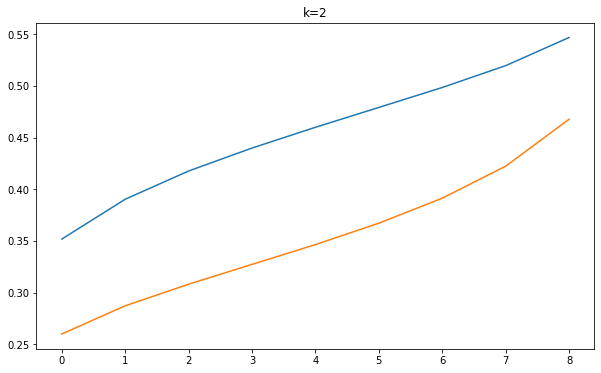

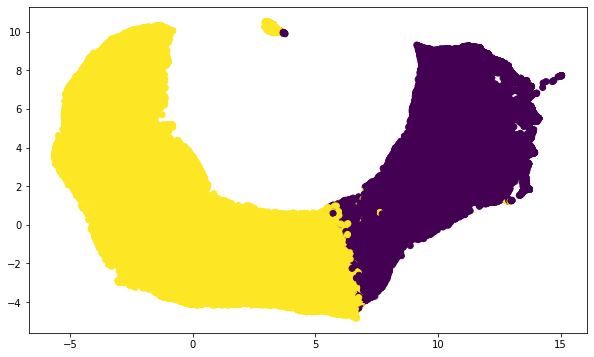

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


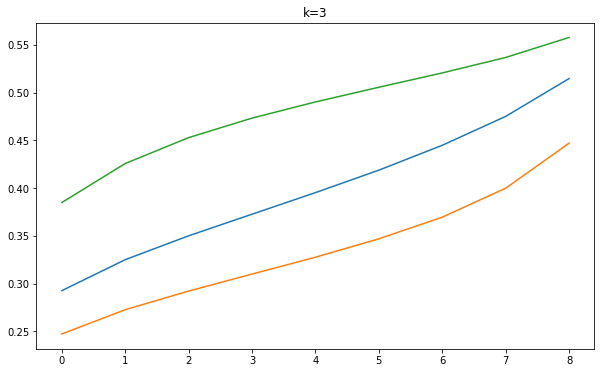

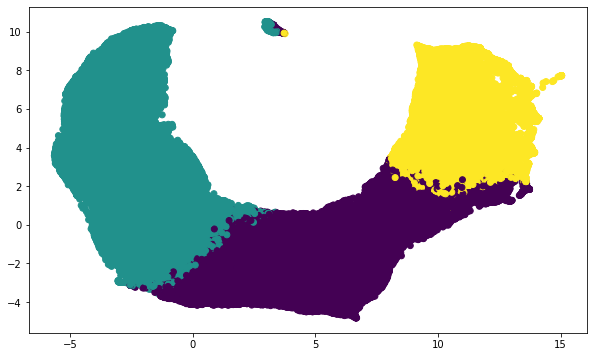

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


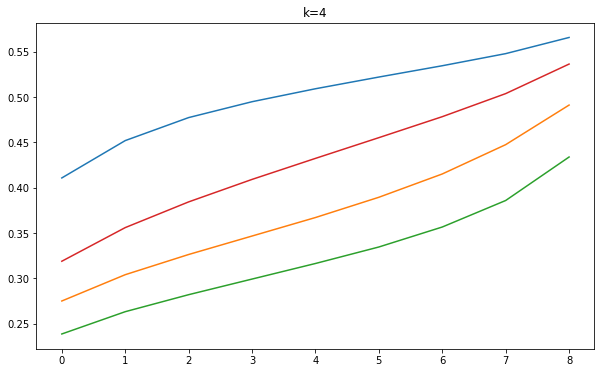

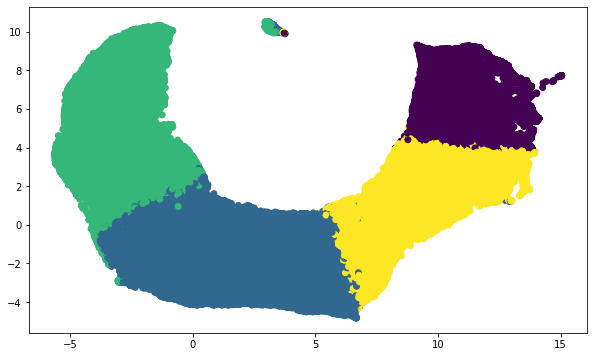

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


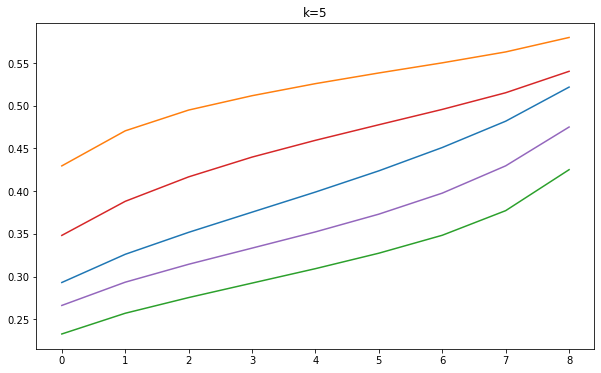

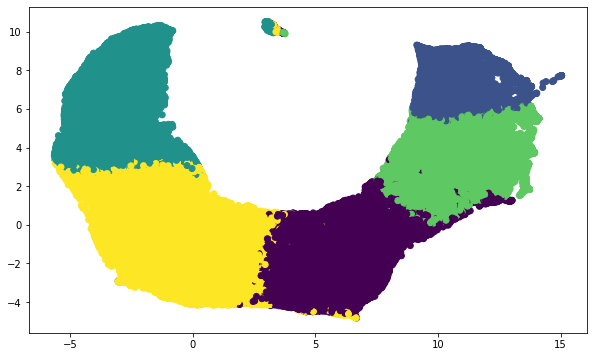

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


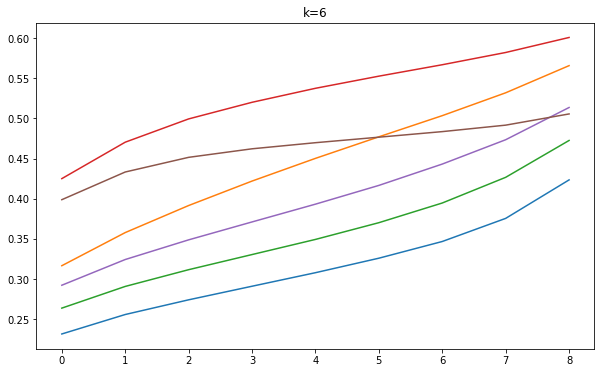

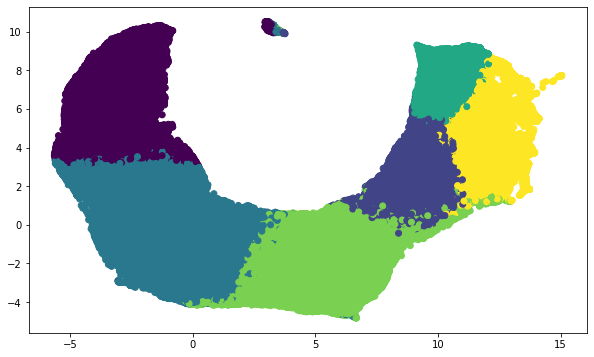

In [86]:
exp_scores=[]
for i in range(2,7):
  clustering_res = KMeans(n_clusters=i, random_state=15).fit(expenditure_activity)
  silhouette = silhouette_score(expenditure_activity,clustering_res.labels_)
  ch = calinski_harabasz_score(expenditure_activity,clustering_res.labels_)
  db = davies_bouldin_score(expenditure_activity,clustering_res.labels_)
  tmp_scores = {"n_clusters": i,
                "silhouette_score": silhouette,
                 "calinski_harabasz_score": ch,
                "davies_bouldin_score": db,
                 }
  exp_scores.append(tmp_scores)
  plt.figure(figsize=(10,6))
  plt.title('k='+str(i))
  for k in range(i):
        plt.plot(clustering_res.cluster_centers_[k])
  plt.show()
  plt.figure(figsize=(10,6))
  plt.scatter(exp_emb[ :, 0], exp_emb[ :, 1],c=clustering_res.labels_)
  plt.show()

In [87]:
exp_scores = pd.DataFrame(exp_scores)
exp_scores

,n_clusters,silhouette_score,calinski_harabasz_score,davies_bouldin_score
0,2,0.499685,144412.697642,0.762984
1,3,0.394100,133529.847364,0.845906
2,4,0.338883,119689.847525,0.957112
3,5,0.299062,106684.225253,1.064794
4,6,0.294912,98716.288719,1.062277


Выделенные профили пользователей по тратам (k=6):

1. Синяя линия: равномерно возрастающая активность по перцентилям, самое низкое среднее значение активности

2. Оранжевая линия: более высокая активность и более высокий прирост по перцентилям

3. Зелёная линия: такая же как синяя, но более высокое среднее

4. Красная линия: наиболее высокие показатели трат

5. Фиолетовая линия: средние возрастающие траты

6. Коричневая линия: почти одинаковые затраты